In [1]:
import os
import sys
from pathlib import Path
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
import numpy as np
import scipy
from scipy.io import loadmat
from scipy import stats, signal

import matplotlib.pyplot as plt
from pathlib import Path
import os
import sys

In [3]:
from utils.data_utils import min_max_per_block_scaling, process_text, process_file_v2, process_string

In [4]:

data_path = Path("/drive/data/competitionData")

train_path = data_path / "train"
test_path  = data_path / "test"
holdout_path = data_path / "competitionHoldOut"

fnames_train = os.listdir(train_path)
fnames_test = os.listdir(test_path)
fnames_holdout = os.listdir(holdout_path)

SFREQ = 50

In [5]:
brain_list, sentence_list, date_list = process_file_v2(train_path / fnames_train[0])
print(len(brain_list))


360


In [8]:
for string in sentence_list:
    print(string)
    print(process_string(string))
    print('----')

After that it was the interior stairs and foyer.
after that it was the interior stairs and foyer
----
Quarantine measures were not seen as necessary.
quarantine measures were not seen as necessary
----
And that's not going to be good.
and that's not going to be good
----
I guess it wasn't a real good topic for us.
i guess it wasn't a real good topic for us
----
I really feel bad for the people I see there.
i really feel bad for the people i see there
----
Since he goes to nursery school.
since he goes to nursery school
----
The commentaries.
the commentaries
----
I just got married last year.
i just got married last year
----
Like when I lived in Washington.
like when i lived in washington
----
But that's how we got into a problem.
but that's how we got into a problem
----
We have Portuguese speakers.
we have portuguese speakers
----
She don't even know how.
she don't even know how
----
We're just friends.
we're just friends
----
This whole thing.
this whole thing
----
Did they have so

In [6]:
# sample_idx = 130
# print(brain_list[sample_idx].shape, sentence_list[sample_idx])
# # plt.figure(figsize = 
# plt.imshow(brain_list[sample_idx][:512].T, aspect = 'auto')
# # plt.colorbar()
# plt.show()
# plt.imshow(brain_list[sample_idx][:, 50::256].T, aspect = 'auto')
# # plt.plot(brain_list[sample_idx][:256, 100])


Very low noise floor.
0


/tmp/ipykernel_7029/4116921406.py:16: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[4].imshow(x[t_st:t_end, c_st+ 1024:c_end+1024].T, )


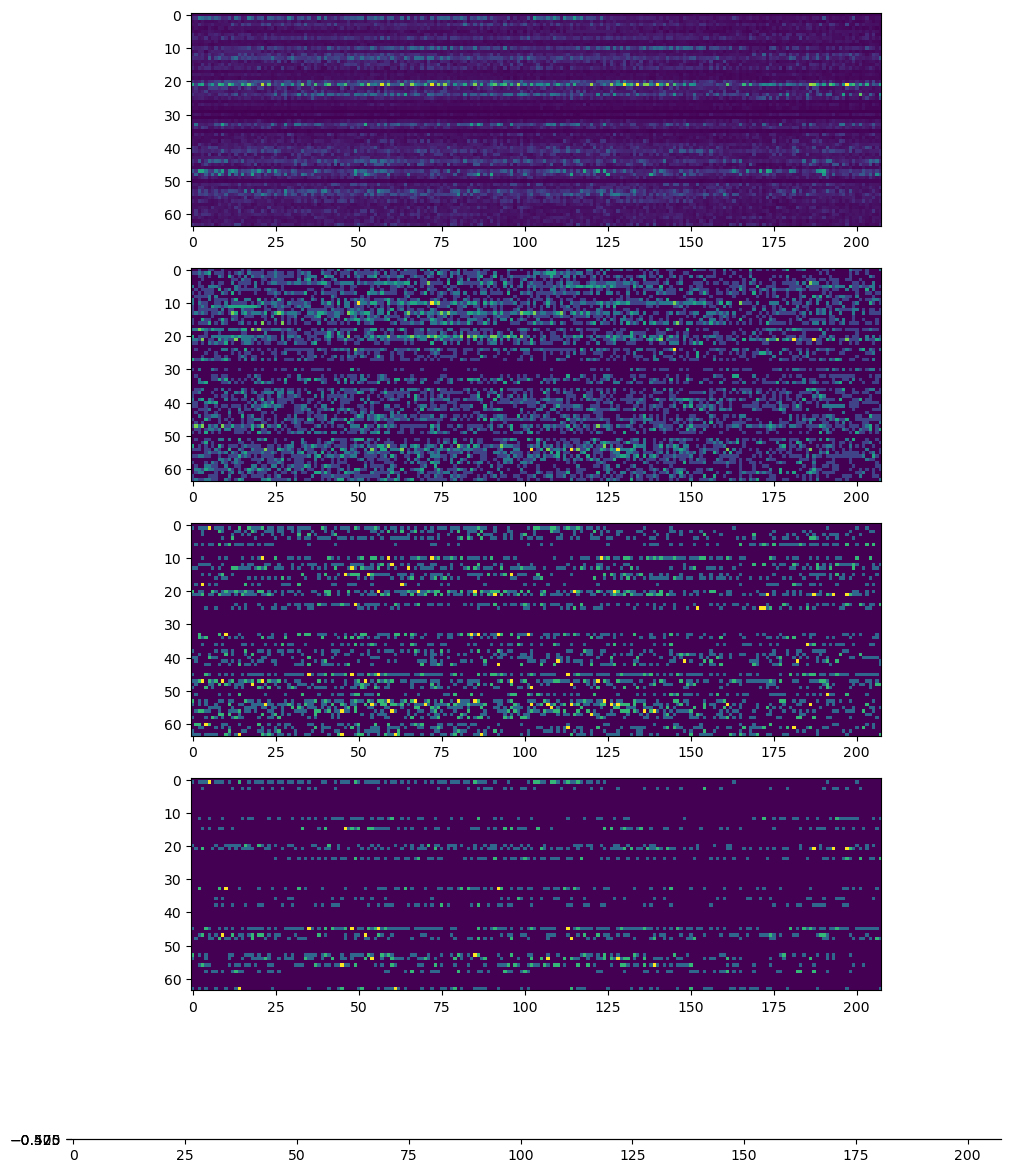

In [7]:
sample_idx = 300
x = brain_list[sample_idx]

print(sentence_list[sample_idx])
print(np.all((x==0), axis=-1).sum())

t_st, t_end = 0, 512
c_st, c_end = 0, 64


fig, ax = plt.subplots(5,1, figsize = (12, 16))
ax[0].imshow(x[t_st:t_end, c_st:c_end].T, )
ax[1].imshow(x[t_st:t_end, 256+c_st:c_end+256].T, )
ax[2].imshow(x[t_st:t_end, c_st+ 512:c_end+512].T, )
ax[3].imshow(x[t_st:t_end, c_st+ 768:c_end+768].T, )
ax[4].imshow(x[t_st:t_end, c_st+ 1024:c_end+1024].T, )

# ax[1].imshow(res[t_st:t_end, c_st:c_end].T, vmax=res.max())
# ax[2].imshow(x_normalized[t_st:t_end, c_st:c_end].T, vmax=1)


In [216]:
# remove outliers and min max scalers for alll electrodes.
low, up = get_low_upper_values(x)
x_clip = np.clip(x, low, up)
x_normalized = (x_clip - x_clip.min(0)) / ( x_clip.max(0) - x_clip.min(0))


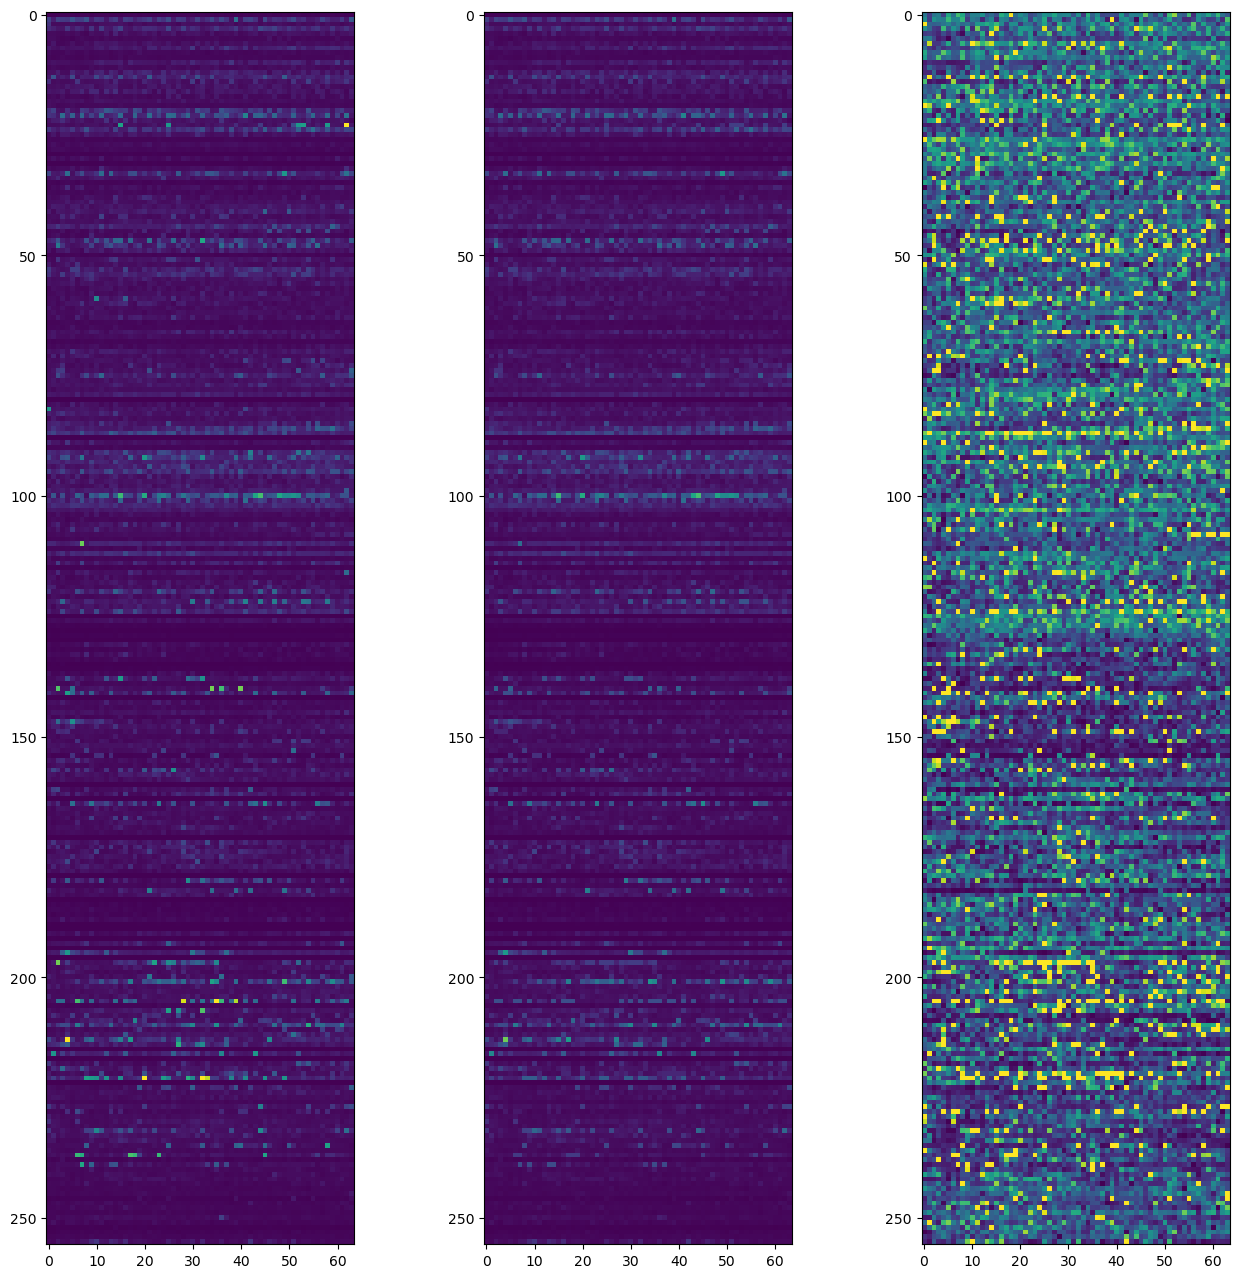

In [217]:
t_st, t_end = 0, 64
c_st, c_end = 0, 256

fig, ax = plt.subplots(1,3, figsize = (16, 16))
ax[0].imshow(x[t_st:t_end, c_st:c_end].T, vmax=res.max())
ax[1].imshow(res[t_st:t_end, c_st:c_end].T, vmax=res.max())
ax[2].imshow(x_normalized[t_st:t_end, c_st:c_end].T, vmax=1)


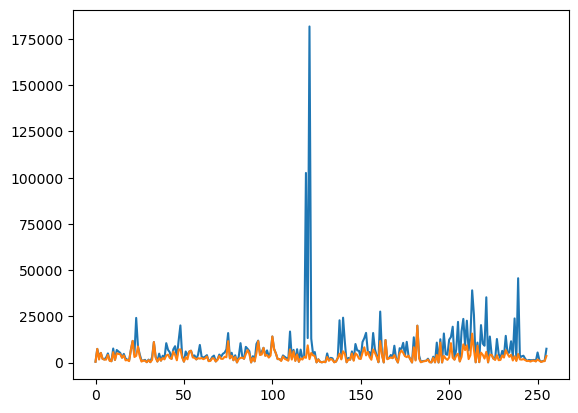

In [79]:
plt.plot(np.max(x, axis=0))
plt.plot(np.max(res, axis=0))

In [80]:
np.argmax(up_lim)

182

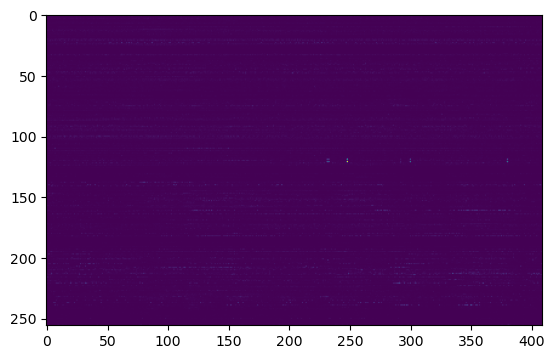

In [81]:
plt.imshow(x.T)

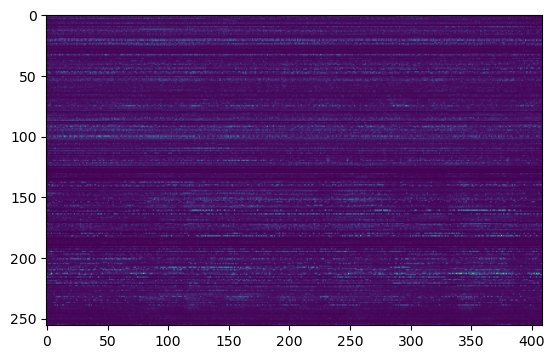

In [82]:
plt.imshow(res.T)

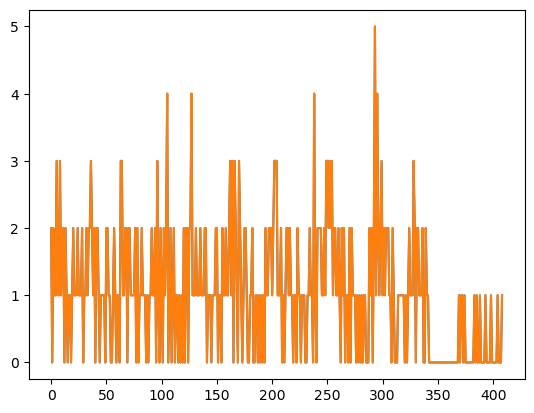

In [62]:
plt.plot(x[:, 1])
plt.plot(res[:, 1])

In [4]:
data = loadmat(test_path / fnames_test[0])
np.unique(data['blockIdx'])

array([14], dtype=uint8)

In [5]:
data = loadmat(holdout_path / fnames_holdout[0])
np.unique(data['blockIdx'])

array([1, 2], dtype=uint8)

In [17]:
tx1 = data['tx1'][0][0]

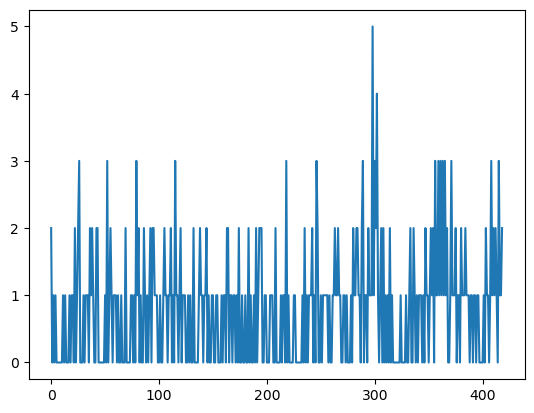

In [19]:
plt.plot(tx1[:, 0])

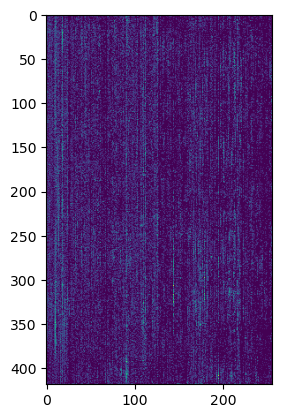

In [18]:
plt.imshow(tx1)

In [6]:
for fname in fnames_train:
    fpath = train_path / fname
    data = loadmat(fpath)
    n_trials = data['blockIdx'].size
    print(f"File {fname}: \n ")  
    total_timepoints = 0
    for trial in range(n_trials):
        total_timepoints += data['spikePow'][0, trial].shape[0]
        
    print(f"# trials = {n_trials}; # timepoints = {total_timepoints / 1000:.0f} 000")
    print(f"Average trial length = {total_timepoints / n_trials / SFREQ:.0f} sec ({total_timepoints / n_trials:.0f}) points \n")

File t12.2022.06.28.mat: 
 
# trials = 360; # timepoints = 104 000
Average trial length = 6 sec (289) points 

File t12.2022.06.02.mat: 
 
# trials = 400; # timepoints = 118 000
Average trial length = 6 sec (295) points 



KeyboardInterrupt: 

The moisture in my eyes is from eyedrops, not from tears.                             


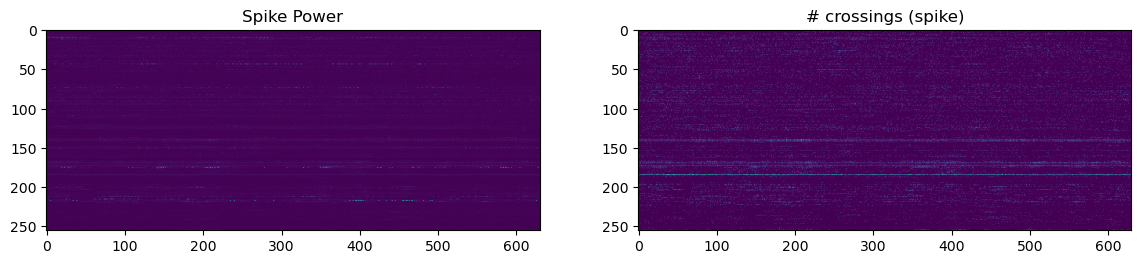

In [9]:
i_file = 0
i_trial = 50

fname = fnames_train[i_file]
fpath = train_path / fname

data = loadmat(fpath)
spikePow = data['spikePow']
tx3 = data['tx3']
tx1 = data['tx1']

print(data['sentenceText'][i_trial])

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

ax = axes[0]
ax.imshow(spikePow[0, i_trial].T)
ax.set_title("Spike Power")

ax = axes[1]
ax.imshow(tx3[0, i_trial].T)
ax.set_title("# crossings (spike)");

In [30]:
tx3[0, i_trial].shape

(389, 256)

The moisture in my eyes is from eyedrops, not from tears.                             


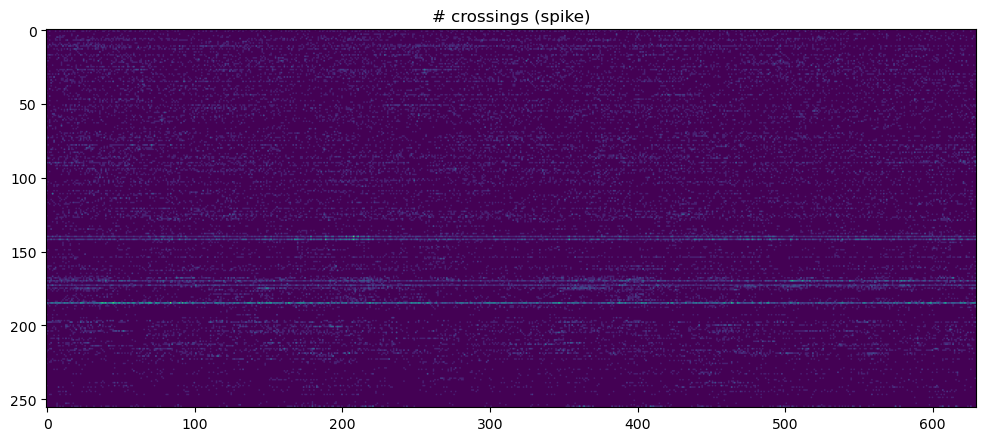

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.set_title("# crossings (spike)");
ax.imshow(tx3[0, i_trial].T)

print(data['sentenceText'][i_trial])

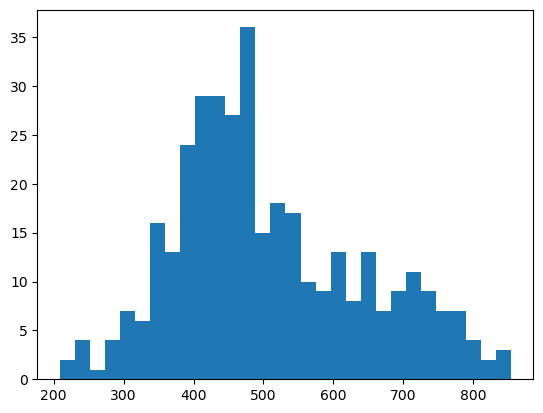

In [15]:
i_file = 1
fname = fnames_train[i_file]
fpath = train_path / fname
data = loadmat(fpath)

n_trials = data['blockIdx'].size
spikePow = data['spikePow']
tx3 = data['tx3']
lengths = []
for i_trial in range(n_trials):
    
    lengths.append(spikePow[0, i_trial].shape[0])
    
plt.hist(lengths, bins=30);

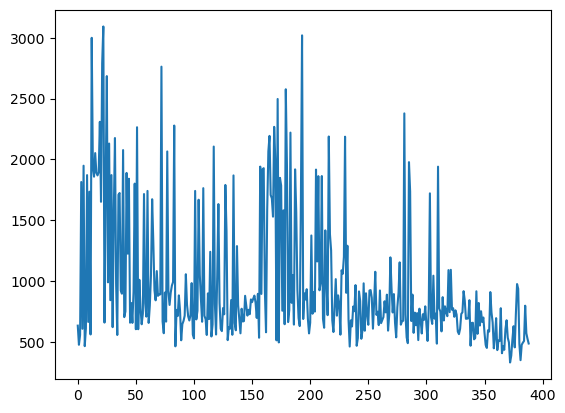

In [12]:
i_chan = 10
plt.plot(spikePow[0, i_trial][:, i_chan])

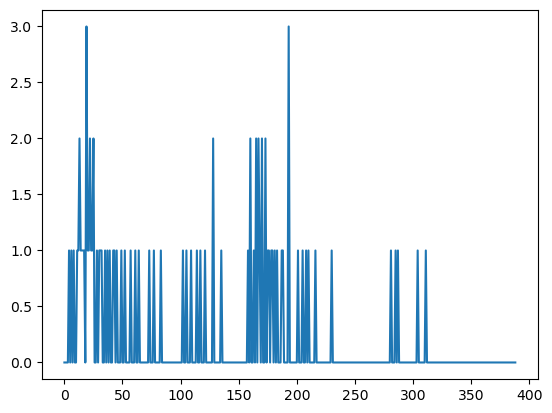

In [16]:
i_chan = 10
plt.plot(tx3[0, i_trial][:, i_chan])

In [85]:
def process_signal(voltage_list, spikes_list, block_list):
    """
    Preprocess voltages / spike counts based on the
    block-consistent features (z-score)
    """
    
    n_trials = len(block_list)
    trial_indices = np.arange(n_trials)
    
    """ Concatenate spikes and voltages """
    # concatenate spike power and threshold crossings along the channels dimension
    
    brain_concat = np.empty(n_trials, dtype=object)
    for i in range(n_trials):
        brain_concat[i] = np.concatenate([voltage_list[i], spikes_list[i]], axis=1)
    
    """ Block-wise Z-score and smoothing """

    brain_processed = np.empty(n_trials, dtype=object)
    
    for block in np.unique(block_list):
        
        trial_mask = block_list == block
        
        brain_appended = np.concatenate(brain_concat[trial_mask], axis=0)
        
        # get row vectors because channels are 2nd dimension (column-wise means and stds)
        block_mean = brain_appended.mean(axis=0)[None, :] 
        block_std  = brain_appended.std(axis=0)[None, :]
        
        block_std[block_std == 0] = 1
        
        # normalize each trial according to the block mean and std (zscore)
        for trial in trial_indices[trial_mask]:
            brain_processed[trial] = (brain_concat[trial] - block_mean) / block_std
            
            """ Gaussian smoothing over time (in the same loop for efficiency)"""
            # here we don't really care if it's causal (does not look into the future)
            # because we are decoding the whole sentence
            brain_processed[trial] = scipy.ndimage.gaussian_filter1d(brain_processed[trial], sigma=1, axis=0)            
            
    return brain_processed

def process_text(arr):
    return [str.strip() for str in arr]

def process_file(data_file):
    
    data = scipy.io.loadmat(data_file)
    date = data_file.stem

    n_trials = data['blockIdx'].shape[0]

    date_list = [date for _ in range(n_trials)]

    voltage_list = data['spikePow'][0][:]
    spikes_list  = data['tx4'][0][:]
    block_list   = data['blockIdx'][:, 0]

    brain_list = process_signal(voltage_list, spikes_list, block_list)
    
    sentence_list = data['sentenceText']
    sentence_list = process_text(sentence_list)

    return brain_list, sentence_list, date_list


def process_all_files(path):
    
    data_res = {'brain_list':[], 'sentence_list':[], 'date_list':[]}
    
    for data_file in sorted(path.glob('*.mat')):

        brains, sentences, dates = process_file(data_file)
        
        data_res['brain_list'].extend(brains)
        data_res['sentence_list'].extend(sentences)
        data_res['date_list'].extend(dates)

    return data_res

In [83]:
X, y, dates = process_file(train_path / fnames_train[0])

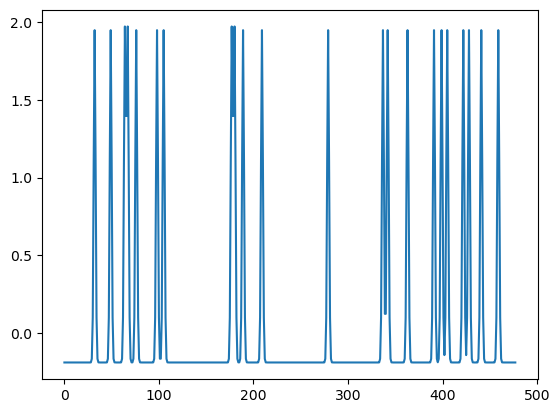

In [84]:
i_trial = 0
i_chan = 270

plt.plot(X[i_trial][:, i_chan])

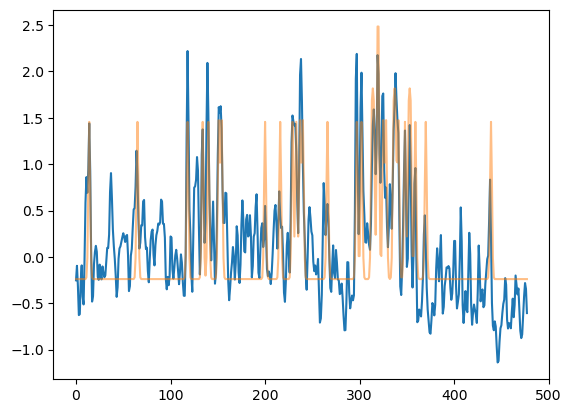

In [91]:
X, y, dates = process_file(train_path / fnames_train[0])

i_trial = 0
i_chan = 5

plt.plot(X[i_trial][:, i_chan])
plt.plot(X[i_trial][:, i_chan + 256], alpha=0.5)

In [78]:
y[i_trial]

'Nuclear rockets can destroy airfields with ease.'

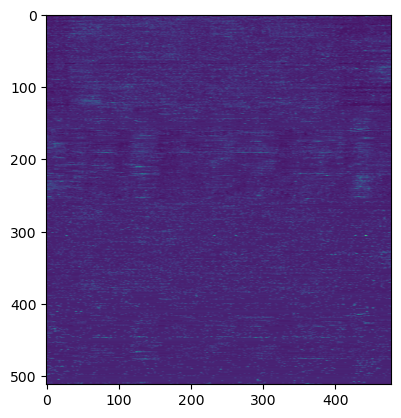

In [79]:
plt.imshow(X[i_trial].T)

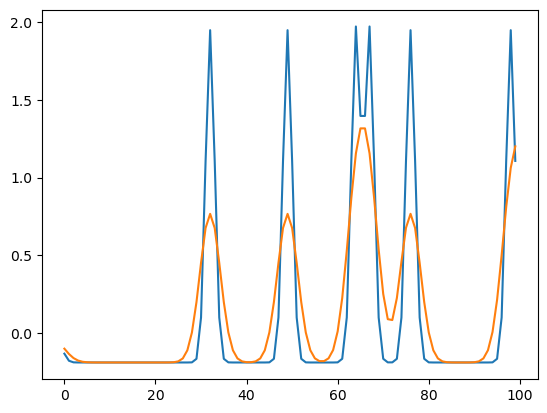

In [81]:
pad_begin = 8
pad_end = 0
n_times = 100
sigma = 2 # 40 ms

sig_orig = X[i_trial][:n_times, i_chan]
sig_padded = np.pad(sig_orig, pad_width=[(pad_begin, pad_end)])
sig_smoothed = scipy.ndimage.gaussian_filter1d(sig_padded, sigma=2)

plt.plot(sig_orig)
#plt.plot(sig_padded)
plt.plot(sig_smoothed[pad_begin:])